In [ ]:
"""
seleccion:
    'elitist'
    'roulette_wheel'
    'boltzmann'  usa pseudo-performance roulette_wheel
    'universal_selection'   
    'deterministic_tournament'
    'stochastic_tournament'
    'rank_based'    usa pseudo-performance roulette_wheel

crossover:
    'one_point'
    'two_point'
    'uniform'
    'annular'

mutation:
    'one_gene'
    'multi_gene'
    'multi_gene_mutation_uniform'
"""

#### Setup

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.8e}'.format

import configparser
from collections import defaultdict
from src.character import Character, CharacterType 
from src.stats import random_stats
from src.genes import  encode_genes, decode_genes
from src.mutation import one_gene_mutation, multi_gene_mutation, multi_gene_mutation_uniform

import sys
sys.path.append("src")

from src.population import generate_init_population, eval_performace
from src.selection import stochastic_tournament_selection, deterministic_tournament_selection, add_relative_accumulate, elitist_selection, roulette_wheel_selection, universal_selection, boltzmann_selection, rank_based_selection
from src.crossover import single_point_crossover, two_point_crossover, uniform_crossover, annular_crossover, normalize_chromosome


In [3]:
from collections import namedtuple

def read_config(filename):
    config = configparser.ConfigParser()
    config.read(filename)
    params = defaultdict(dict)
    for section in config.sections():
        for key, value in config.items(section):
            params[section][key] = value
    return params

#params = read_config('config_file.config')

def parameters():
    
    config_params = read_config('config_file.config')

    # Personaje 
    type = eval(config_params['CHARACTER']['type'])
    
    # sum( stats ) = 150
    maxStatsValue = eval(config_params['M']['m'])
    
    # N
    populationNumber = eval(config_params['N']['n'])
    # K
    k = eval(config_params['K']['k'])

    # Numero máximo de generaciones - criterio de corte
    numberOfGenerations = eval(config_params['GENERATIONS']['number'])
    
    # A%
    method1Percentage = eval(config_params['METHOD1PERCENTAGE']['percentage'])
    selectionMethod1 = eval(config_params['SELECTION_METHOD']['method1'])
    selectionMethod2 = eval(config_params['SELECTION_METHOD']['method2'])
   
    # CrossOver
    metodo_cruza = eval(config_params['metodo_cruza']['crossover'])
 
    # Mutation
    mutation_type = eval(config_params['MUTATION']['mutation_type'])
    mutation_rate = eval(config_params['MUTATION']['mutation_rate'])

    # B%
    methodReplacePercentage = eval(config_params['METHODRePERCENTAGE']['percentage'])
    metodo_reemplazo3 = eval(config_params['metodo_reemplazo']['metodo1'])
    metodo_reemplazo4 = eval(config_params['metodo_reemplazo']['metodo2'])

    cutCriteria = eval(config_params['CUT_CRITERIA']['criteria_type'])
    
    # Selector parameters
    # M
    tournament_size = eval(config_params['deterministic_tournament_selection']['tournament_size'])
    # stochastic_tournament_selection
    threhold = eval(config_params['stochastic_tournament_selection']['threshold'])
    # Boltzmann parameters
    boltzmannT_0 = eval(config_params['BOLTZMANN']['t_0'])
    boltzmannT_c = eval(config_params['BOLTZMANN']['t_c'])
    boltzmannM = eval(config_params['BOLTZMANN']['m'])

    Param = namedtuple('Param',[
        'character',
        'maxStatsValue',
        'populationNumber',
        'k',
        'numberOfGenerations',
        'method1Percentage',
        'selectionMethod1',
        'selectionMethod2',
        'metodo_cruza',
        'mutation_type',
        'mutation_rate',
        'methodReplacePercentage',
        'metodo_reemplazo3',
        'metodo_reemplazo4',
        'cutCriteria',
        'tournament_size',
        'threhold',
        'boltzmannT_0',
        'boltzmannT_c',
        'boltzmannM'
    ])    

    parametros = Param(
                character=type,
                maxStatsValue=maxStatsValue,
                populationNumber=populationNumber,
                k=k,
                numberOfGenerations=numberOfGenerations,
                method1Percentage=method1Percentage,
                selectionMethod1=selectionMethod1,
                selectionMethod2=selectionMethod2,
                metodo_cruza=metodo_cruza,
                mutation_type=mutation_type,
                mutation_rate=mutation_rate,
                methodReplacePercentage=methodReplacePercentage,
                metodo_reemplazo3=metodo_reemplazo3,
                metodo_reemplazo4=metodo_reemplazo4,
                cutCriteria=cutCriteria,
                tournament_size=tournament_size,
                threhold=threhold,
                boltzmannT_0=boltzmannT_0,
                boltzmannT_c=boltzmannT_c,
                boltzmannM=boltzmannM
    )

    return parametros

#p = parameters()


In [ ]:
"""
from src.character import Character, CharacterType 
import sys
sys.path.append("src")

from src.population import generate_init_population

#GENERACION 0

generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
generacion = 0
"""


In [ ]:
"""
# GUARDO EL MAS APTO DE LA GENERACION 0
# Escribe la poblacion inicial.
#generation_0.insert(0, 'generation', int(generacion))
generation_0['generation'] = generacion
mas_apto_G0 = generation_0.head(1)
mas_apto_G0.to_csv(f'datos-Prueba1.csv', mode='w', index=False)
"""


#### Functions

In [3]:

def method_selector(Kt, method1Percentage): 
    # Selecciono K individuos
    # Utilizo el porcentaje para cada método
    K1 = int(np.round(Kt * method1Percentage))
    K2 = Kt - K1
    return K1, K2

#k1, k2 = method_selector(p.k, p.method1Percentage)

In [12]:
#current_generation = generation_0
#generacion = 0

In [13]:
def selection_method(poblacion, ki, params, method, generation):

    if(method == 'elitist'):
        selected = elitist_selection(poblacion, ki)
    elif(method == 'roulette_wheel'):
        selected = roulette_wheel_selection(poblacion, ki)
    elif(method == 'boltzmann'):
        selected = boltzmann_selection(poblacion, ki, generation, params.boltzmannT_0,params.boltzmannT_c,params.boltzmannM)
    elif(method == 'universal_selection'):
        selected = universal_selection(poblacion, ki)
    elif(method == 'deterministic_tournament'):
        selected = deterministic_tournament_selection(poblacion, params.tournament_size, ki)
    elif(method == 'stochastic_tournament'):
        selected = stochastic_tournament_selection(poblacion, ki, params.threhold)
    elif(method == 'rank_based'):
        selected = rank_based_selection(poblacion, ki)
    return selected
"""
# SELECCION DE PADRES
generacion_sel1 = selection_method(current_generation, k1, p, p.selectionMethod1, generacion)
generacion_sel2 = selection_method(current_generation, k2, p, p.selectionMethod2, generacion)

# SELECCION TOTAL: K padres
selection_total = pd.concat([generacion_sel1, generacion_sel2])

selection_total.drop(columns=['performance_relative'], inplace=True)
selection_total.drop(columns=['performance_accumulated'], inplace=True)
selection_total = selection_total.sort_values(by='performance', ascending=False)
selection_total.reset_index(drop=True, inplace=True)
"""


"\n# SELECCION DE PADRES\ngeneracion_sel1 = selection_method(current_generation, k1, p, p.selectionMethod1, generacion)\ngeneracion_sel2 = selection_method(current_generation, k2, p, p.selectionMethod2, generacion)\n\n# SELECCION TOTAL: K padres\nselection_total = pd.concat([generacion_sel1, generacion_sel2])\n\nselection_total.drop(columns=['performance_relative'], inplace=True)\nselection_total.drop(columns=['performance_accumulated'], inplace=True)\nselection_total = selection_total.sort_values(by='performance', ascending=False)\nselection_total.reset_index(drop=True, inplace=True)\n"

In [6]:
#cromosomas = encode_genes(selection_total)

#cromosomas

In [14]:
def crossover_method(poblacion, method):
    
    if(method == 'one_point'):
        crossed = single_point_crossover(poblacion)
    elif(method == 'two_point'):
        crossed = two_point_crossover(poblacion)
    elif(method == 'uniform'):
        crossed = uniform_crossover(poblacion)
    elif(method == 'annular'):
        crossed = annular_crossover(poblacion)
    
    return crossed

#crossed_result = crossover_method(cromosomas, p.metodo_cruza)

#crossed_result

In [15]:
def mutation_method(poblacion, rate, method):
    
    if(method == 'one_gene'):
        mutated = one_gene_mutation(poblacion, rate)
    elif(method == 'multi_gene'):
        mutated = multi_gene_mutation(poblacion, rate)
    elif(method == 'multi_gene_mutation_uniform'):
        mutated = multi_gene_mutation_uniform(poblacion, rate)
    
    return mutated

#mutation_result = mutation_method(crossed_result, p.mutation_rate, p.mutation_type)

#mutation_result

In [16]:
#cromosomas_norm = normalize_chromosome(mutation_result)

#cromosomas_norm

In [10]:
"""
cromosomas_norm_decode = decode_genes(cromosomas_norm)
offspring = eval_performace(cromosomas_norm_decode,p.character)

offspring = offspring.sort_values(by='performance', ascending=False)
offspring.reset_index(drop=True, inplace=True)

offspring

"""

"\ncromosomas_norm_decode = decode_genes(cromosomas_norm)\noffspring = eval_performace(cromosomas_norm_decode,p.character)\n\noffspring = offspring.sort_values(by='performance', ascending=False)\noffspring.reset_index(drop=True, inplace=True)\n\noffspring\n\n"

In [11]:
"""
# REEMPLAZO
# padres:  selection_total de tamaño K
# hijos: offspring  de tamaño K
# tomo K de los hijos
k_reemplazo_metodo3 = p.k
# el resto para completar N
k_reemplazo_metodo4 = p.populationNumber - p.k

# SELECCION DE PADRES
generacion_reemp1 = selection_method(offspring, k_reemplazo_metodo3, p, p.metodo_reemplazo3, generacion)
generacion_reemp2 = selection_method(selection_total, k_reemplazo_metodo4, p, p.metodo_reemplazo4, generacion)

# SELECCION TOTAL: K padres
new_generation = pd.concat([generacion_reemp1, generacion_reemp2])

new_generation.drop(columns=['performance_relative'], inplace=True)
new_generation.drop(columns=['performance_accumulated'], inplace=True)
new_generation = new_generation.sort_values(by='performance', ascending=False)
new_generation.reset_index(drop=True, inplace=True)

new_generation
"""

"\n# REEMPLAZO\n# padres:  selection_total de tamaño K\n# hijos: offspring  de tamaño K\n# tomo K de los hijos\nk_reemplazo_metodo3 = p.k\n# el resto para completar N\nk_reemplazo_metodo4 = p.populationNumber - p.k\n\n# SELECCION DE PADRES\ngeneracion_reemp1 = selection_method(offspring, k_reemplazo_metodo3, p, p.metodo_reemplazo3, generacion)\ngeneracion_reemp2 = selection_method(selection_total, k_reemplazo_metodo4, p, p.metodo_reemplazo4, generacion)\n\n# SELECCION TOTAL: K padres\nnew_generation = pd.concat([generacion_reemp1, generacion_reemp2])\n\nnew_generation.drop(columns=['performance_relative'], inplace=True)\nnew_generation.drop(columns=['performance_accumulated'], inplace=True)\nnew_generation = new_generation.sort_values(by='performance', ascending=False)\nnew_generation.reset_index(drop=True, inplace=True)\n\nnew_generation\n"

In [ ]:
"""
generacion += 1
# GUARDO EL MAS APTO DE LA GENERACION NUEVA
# Escribe la poblacion inicial.

#new_generation.insert(0, 'generation', int(generacion))
new_generation['generation'] = generacion
mas_apto_NG = new_generation.head(1)
mas_apto_NG.to_csv(f'datos-Prueba1.csv', mode='a', header=False, index=False)
"""

#### Selections

In [17]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

generation_0.to_csv(f'generation0.csv', mode='w', index=False)
generation_0

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,73,47,13,5,12,2.00000000e+00,CharacterType.ARCHER,4.35350819e+01
1,55,64,1,3,27,1.40000000e+00,CharacterType.ARCHER,3.68873670e+01
2,75,15,38,11,11,1.90000000e+00,CharacterType.ARCHER,3.59012906e+01
3,54,31,37,1,27,1.50000000e+00,CharacterType.ARCHER,3.33315267e+01
4,35,41,42,31,1,1.90000000e+00,CharacterType.ARCHER,3.22910430e+01
...,...,...,...,...,...,...,...,...
75,3,97,15,5,30,2.00000000e+00,CharacterType.ARCHER,3.79879272e+00
76,11,1,23,99,16,1.70000000e+00,CharacterType.ARCHER,3.56774757e+00
77,7,33,12,97,1,1.60000000e+00,CharacterType.ARCHER,3.37986942e+00
78,2,33,65,11,39,1.90000000e+00,CharacterType.ARCHER,3.36854240e+00


In [18]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

elitist_selection = elitist_selection(generation_0,p.k)
elitist_selection.to_csv(f'elitist_selection.csv', mode='w', index=False)

elitist_selection

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,57,54,16,3,20,1.90000000e+00,CharacterType.ARCHER,4.65727003e+01
1,34,32,70,10,4,1.90000000e+00,CharacterType.ARCHER,3.38221995e+01
2,33,74,21,3,19,1.50000000e+00,CharacterType.ARCHER,3.13510310e+01
3,27,72,21,11,19,1.90000000e+00,CharacterType.ARCHER,3.02408899e+01
4,71,29,11,14,25,1.80000000e+00,CharacterType.ARCHER,2.98209774e+01
5,46,36,22,21,25,1.80000000e+00,CharacterType.ARCHER,2.90157412e+01
6,51,16,42,37,4,1.90000000e+00,CharacterType.ARCHER,2.87187797e+01
7,39,24,59,9,19,1.70000000e+00,CharacterType.ARCHER,2.60268405e+01
8,62,4,47,28,9,1.90000000e+00,CharacterType.ARCHER,2.59244672e+01
9,41,34,29,6,40,1.50000000e+00,CharacterType.ARCHER,2.58917091e+01


In [19]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

roulette_wheel_selection = roulette_wheel_selection(generation_0,p.k)
roulette_wheel_selection.to_csv(f'roulette_wheel_selection.csv', mode='w', index=False)

roulette_wheel_selection

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,37,31,45,6,31,1.60000000e+00,CharacterType.ARCHER,2.46973048e+01
1,24,95,15,6,10,1.80000000e+00,CharacterType.ARCHER,2.71072823e+01
2,105,24,6,10,5,1.80000000e+00,CharacterType.ARCHER,2.93726247e+01
3,53,45,8,1,43,1.40000000e+00,CharacterType.ARCHER,2.96067406e+01
4,13,5,2,114,16,2.00000000e+00,CharacterType.ARCHER,2.39234824e+00
5,43,15,40,11,41,1.40000000e+00,CharacterType.ARCHER,2.10665169e+01
6,87,20,30,11,2,1.90000000e+00,CharacterType.ARCHER,3.99800353e+01
7,53,45,8,1,43,1.40000000e+00,CharacterType.ARCHER,2.96067406e+01
8,28,39,16,12,55,1.30000000e+00,CharacterType.ARCHER,1.19893576e+01
9,52,49,5,12,32,1.40000000e+00,CharacterType.ARCHER,3.02710078e+01


In [20]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
max_generations = p.numberOfGenerations
print(f'max_generations = {p.numberOfGenerations}')

# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

# Example BOLTZMANN


max_generation = p.numberOfGenerations
generation = 3
k = p.k                                 # Number of desired selected individuals.
T_0 = p.boltzmannT_0                                # Initial temperature.
T_c = p.boltzmannT_c                          # Offset value for temperature exponential function.
#reference_generation = max_generation   # Reference generation where 0 < (T_0 - T_offset) = 0.015 = deltaT is desired.
#deltaT = 0.015                          # 0 < (T_0 - T_offset) = deltaT at reference generation.
#m = - (np.log(deltaT) - np.log(T_0 - T_offset)) / reference_generation
m = p.boltzmannM
print(f'T_0= {T_0}')
print(f'T_c= {T_c}')
print(f'm= {m}')

new_boltzmann_selection = boltzmann_selection(generation_0,k,generation,T_0,T_c,m)

#new_boltzmann_selection = boltzmann_selection(generation_0,60,3,T_0,T_c,m)

new_boltzmann_selection.to_csv(f'boltzmann_selection.csv', mode='w', index=False)
new_boltzmann_selection

N = 80
K = 60
max_generations = 200
T_0= 50
T_c= 2
m= 0.02


,strength,agility,expertise,resistance,life,height,characterType,performance
0,43,69,26,10,2,1.50000000e+00,CharacterType.ARCHER,3.94117581e+01
1,43,69,26,10,2,1.50000000e+00,CharacterType.ARCHER,3.94117581e+01
2,58,45,10,16,21,1.90000000e+00,CharacterType.ARCHER,3.88799514e+01
3,52,41,13,11,33,1.90000000e+00,CharacterType.ARCHER,3.45365775e+01
4,49,12,64,6,19,1.90000000e+00,CharacterType.ARCHER,3.24515576e+01
5,74,37,6,31,2,1.40000000e+00,CharacterType.ARCHER,3.16553030e+01
6,47,52,4,10,37,1.80000000e+00,CharacterType.ARCHER,3.07815573e+01
7,47,52,4,10,37,1.80000000e+00,CharacterType.ARCHER,3.07815573e+01
8,35,74,20,18,3,1.60000000e+00,CharacterType.ARCHER,3.03936894e+01
9,74,27,15,29,5,1.40000000e+00,CharacterType.ARCHER,2.87856711e+01


In [4]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

universal_selection = universal_selection(generation_0,p.k)

universal_selection.to_csv(f'universal_selection.csv', mode='w', index=False)
universal_selection

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,58,61,9,15,7,1.60000000e+00,CharacterType.ARCHER,3.78124311e+01
1,58,61,9,15,7,1.60000000e+00,CharacterType.ARCHER,3.78124311e+01
2,72,45,1,9,23,2.00000000e+00,CharacterType.ARCHER,3.58530310e+01
3,72,45,1,9,23,2.00000000e+00,CharacterType.ARCHER,3.58530310e+01
4,77,23,26,23,1,1.80000000e+00,CharacterType.ARCHER,3.38605703e+01
5,77,23,26,23,1,1.80000000e+00,CharacterType.ARCHER,3.38605703e+01
6,81,38,2,22,7,1.40000000e+00,CharacterType.ARCHER,3.24706010e+01
7,58,49,8,7,28,1.60000000e+00,CharacterType.ARCHER,3.19855878e+01
8,58,49,8,7,28,1.60000000e+00,CharacterType.ARCHER,3.19855878e+01
9,35,67,22,21,5,1.70000000e+00,CharacterType.ARCHER,2.96234556e+01


In [22]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

deterministic_tournament = deterministic_tournament_selection(generation_0,p.tournament_size,p.k)

deterministic_tournament.to_csv(f'deterministic_tournament.csv', mode='w', index=False)
deterministic_tournament

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,34,36,21,43,16,1.30000000e+00,CharacterType.ARCHER,1.37417843e+01
1,16,3,57,72,2,1.70000000e+00,CharacterType.ARCHER,6.79757138e+00
2,7,83,41,12,7,1.60000000e+00,CharacterType.ARCHER,7.97667094e+00
3,17,34,25,72,2,1.90000000e+00,CharacterType.ARCHER,1.23438694e+01
4,25,15,51,26,33,1.70000000e+00,CharacterType.ARCHER,1.48625691e+01
5,17,18,11,8,96,1.60000000e+00,CharacterType.ARCHER,6.20368263e+00
6,33,76,5,18,18,1.70000000e+00,CharacterType.ARCHER,2.65827578e+01
7,7,83,41,12,7,1.60000000e+00,CharacterType.ARCHER,7.97667094e+00
8,4,1,48,82,15,1.80000000e+00,CharacterType.ARCHER,2.88883010e+00
9,62,7,33,29,19,1.70000000e+00,CharacterType.ARCHER,1.86181342e+01


In [23]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

stochastic_tournament_selection = stochastic_tournament_selection(generation_0, p.k, p.threhold)

stochastic_tournament_selection.to_csv(f'stochastic_tournament_selection.csv', mode='w', index=False)
stochastic_tournament_selection

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,25,10,24,24,67,1.40000000e+00,CharacterType.ARCHER,9.95517832e+00
1,8,11,33,67,31,1.50000000e+00,CharacterType.ARCHER,5.58272099e+00
2,73,12,52,3,10,1.70000000e+00,CharacterType.ARCHER,3.13239592e+01
3,67,48,6,16,13,1.90000000e+00,CharacterType.ARCHER,4.33566127e+01
4,15,46,51,36,2,1.40000000e+00,CharacterType.ARCHER,1.37819395e+01
5,11,57,17,15,50,1.70000000e+00,CharacterType.ARCHER,9.58182193e+00
6,46,16,57,4,27,2.00000000e+00,CharacterType.ARCHER,2.80853910e+01
7,44,22,39,41,4,1.60000000e+00,CharacterType.ARCHER,2.21741238e+01
8,55,41,16,32,6,1.30000000e+00,CharacterType.ARCHER,1.99083909e+01
9,39,54,11,37,9,1.60000000e+00,CharacterType.ARCHER,2.54307348e+01


In [6]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

rank_based_selection1 = rank_based_selection(generation_0, p.k)

rank_based_selection1.to_csv(f'rank_based_selection.csv', mode='w', index=False)
rank_based_selection1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,37,59,6,7,41,1.80000000e+00,CharacterType.ARCHER,2.80586331e+01
1,72,47,11,1,19,1.30000000e+00,CharacterType.ARCHER,2.52947974e+01
2,52,13,44,5,36,1.70000000e+00,CharacterType.ARCHER,2.32420361e+01
3,21,80,16,5,28,2.00000000e+00,CharacterType.ARCHER,2.16092482e+01
4,46,15,25,19,45,2.00000000e+00,CharacterType.ARCHER,1.85887415e+01
5,46,15,25,19,45,2.00000000e+00,CharacterType.ARCHER,1.85887415e+01
6,22,52,33,25,18,1.60000000e+00,CharacterType.ARCHER,1.83451996e+01
7,36,7,42,33,32,1.90000000e+00,CharacterType.ARCHER,1.76477814e+01
8,46,15,22,62,5,1.80000000e+00,CharacterType.ARCHER,1.68870297e+01
9,16,40,41,34,19,1.90000000e+00,CharacterType.ARCHER,1.57214507e+01


#### Crossover

In [8]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
#generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
df = pd.read_csv('selection_total.csv')
cromosomas1 = encode_genes(df)
crossover_individuals1 = single_point_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'single_point_crossover.csv', mode='w', index=False)

#crossover_individuals1

N = 80
K = 60


In [9]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
#generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
df = pd.read_csv('selection_total.csv')
cromosomas1 = encode_genes(df)
crossover_individuals1 = two_point_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'two_point_crossover.csv', mode='w', index=False)

#crossover_individuals1

N = 80
K = 60


In [10]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
#generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
df = pd.read_csv('selection_total.csv')
cromosomas1 = encode_genes(df)
crossover_individuals1 = annular_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'annular_crossover.csv', mode='w', index=False)

#crossover_individuals1

N = 80
K = 60


In [11]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
#generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
df = pd.read_csv('selection_total.csv')
cromosomas1 = encode_genes(df)
crossover_individuals1u = uniform_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'uniform_crossover.csv', mode='w', index=False)

crossover_individuals1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,7.40000000e+01,7.30000000e+01,3.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.17042944e+01
1,7.40000000e+01,7.30000000e+01,3.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.17042944e+01
2,7.70000000e+01,7.20000000e+01,1.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.16520445e+01
3,7.20000000e+01,7.10000000e+01,7.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15942030e+01
4,7.20000000e+01,7.10000000e+01,7.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15942030e+01
5,7.20000000e+01,7.10000000e+01,7.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15942030e+01
6,7.60000000e+01,6.80000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15422472e+01
7,7.60000000e+01,6.80000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15422472e+01
8,7.60000000e+01,6.80000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15422472e+01
9,7.60000000e+01,6.80000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15422472e+01


#### Mutation

In [18]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
#generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
df = pd.read_csv('selection_total.csv')
cromosomas1 = encode_genes(df)

mutated_individuals1u = one_gene_mutation(cromosomas1, p.mutation_rate)
cromosomas_norm1 = normalize_chromosome(mutated_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
mutated_individuals1 = eval_performace(cromosomas_decod1, p.character)
mutated_individuals1 = mutated_individuals1.sort_values(by='performance', ascending=False)
mutated_individuals1.reset_index(drop=True, inplace=True)

mutated_individuals1.to_csv(f'one_gene_mutation.csv', mode='w', index=False)

mutated_individuals1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,7.20000000e+01,7.10000000e+01,7.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15942030e+01
1,7.60000000e+01,6.80000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15422472e+01
2,7.60000000e+01,6.80000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15422472e+01
3,7.40000000e+01,7.00000000e+01,5.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.10577450e+01
4,7.30000000e+01,7.00000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.10379159e+01
5,7.60000000e+01,6.80000000e+01,5.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.09555546e+01
6,6.90000000e+01,7.60000000e+01,4.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.08439703e+01
7,7.70000000e+01,6.60000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.08019705e+01
8,8.10000000e+01,6.80000000e+01,0.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.05960060e+01
9,8.10000000e+01,6.50000000e+01,3.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.04059951e+01


In [19]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
#generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
df = pd.read_csv('selection_total.csv')
cromosomas1 = encode_genes(df)

mutated_individuals1u = multi_gene_mutation(cromosomas1, p.mutation_rate)
cromosomas_norm1 = normalize_chromosome(mutated_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
mutated_individuals1 = eval_performace(cromosomas_decod1, p.character)
mutated_individuals1 = mutated_individuals1.sort_values(by='performance', ascending=False)
mutated_individuals1.reset_index(drop=True, inplace=True)

mutated_individuals1.to_csv(f'multi_gene_mutation.csv', mode='w', index=False)

mutated_individuals1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,7.20000000e+01,7.10000000e+01,7.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15942030e+01
1,7.60000000e+01,6.80000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15422472e+01
2,7.40000000e+01,7.20000000e+01,3.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.11117531e+01
3,7.20000000e+01,7.20000000e+01,5.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.10539592e+01
4,7.30000000e+01,7.00000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.10379159e+01
5,7.10000000e+01,7.40000000e+01,4.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.10208898e+01
6,7.60000000e+01,6.80000000e+01,5.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.09555546e+01
7,7.20000000e+01,6.40000000e+01,1.30000000e+01,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.06366771e+01
8,8.10000000e+01,6.80000000e+01,0.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.05960060e+01
9,6.70000000e+01,7.70000000e+01,5.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.05806878e+01


In [20]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
#generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
df = pd.read_csv('selection_total.csv')
cromosomas1 = encode_genes(df)

mutated_individuals1u = multi_gene_mutation_uniform(cromosomas1, p.mutation_rate)
cromosomas_norm1 = normalize_chromosome(mutated_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
mutated_individuals1 = eval_performace(cromosomas_decod1, p.character)
mutated_individuals1 = mutated_individuals1.sort_values(by='performance', ascending=False)
mutated_individuals1.reset_index(drop=True, inplace=True)

mutated_individuals1.to_csv(f'multi_gene_mutation_uniform.csv', mode='w', index=False)

mutated_individuals1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,7.20000000e+01,7.10000000e+01,7.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15942030e+01
1,7.60000000e+01,6.80000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15422472e+01
2,7.60000000e+01,6.80000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15422472e+01
3,7.60000000e+01,6.80000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.15422472e+01
4,7.50000000e+01,7.20000000e+01,2.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.11122655e+01
5,7.40000000e+01,7.20000000e+01,3.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.11117531e+01
6,6.70000000e+01,7.60000000e+01,6.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.05922640e+01
7,7.30000000e+01,7.40000000e+01,1.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.05441714e+01
8,7.30000000e+01,7.30000000e+01,2.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.05364301e+01
9,7.30000000e+01,6.80000000e+01,7.00000000e+00,0.00000000e+00,0.00000000e+00,1.90000000e+00,CharacterType.ARCHER,6.03826906e+01


### Motor AG

In [2]:
from main2 import main

main()



N = 80
K = 60
max_generations = 200


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def graphMotor(config):
    # Cargar los datos desde el archivo CSV
    df = pd.read_csv(config)

    # Encontrar el valor máximo y mínimo de la columna 'performance'
    max_performance = df['performance'].max()
    min_performance = df['performance'].min()

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.plot(df['generation'], df['performance'], label='Performance')
    plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=70)
    plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=70)
    plt.xlabel('Generación')
    plt.ylabel('Performance')
    plt.title('Performance de cada generación', fontsize=20)
    plt.legend()
    plt.grid(True)

    # Anotar los valores mínimo y máximo
    plt.annotate(f'Máximo: {max_performance}', 
                xy=(df['generation'].iloc[df['performance'].idxmax()], max_performance),
                xytext=(0, 50), textcoords='offset points',
                arrowprops=dict(facecolor='red', arrowstyle='->'))

    plt.annotate(f'Mínimo: {min_performance}', 
                xy=(df['generation'].iloc[df['performance'].idxmin()], min_performance),
                xytext=(1, -45), textcoords='offset points',
                arrowprops=dict(facecolor='green', arrowstyle='->'))

    # Información adicional hacia la derecha de la leyenda del eje x
    plt.text(1.05, 0.5, """
                \n CONFIG
                \n Jugador = ARCHER
                N = 80
                K = 60
                
                \n [SELECTION_METHOD]
                Porcentaje para el método 1 de Seleccion.
                percentage = 0.7
                method1 = 'universal_selection'
                method2 = 'stochastic_tournament'
                
                threshold = 0.7                              
                
                CROSSOVER = 'two_point'
                
                MUTATION = 'one_gene'
                mutation_rate = 0.3

                \n [REPLACE_METHOD] 
                Porcentaje para el método 1 de reemplazo.
                percentage = 0.4
                metodo1 = 'elitist'
                metodo2 = 'boltzmann'
                
                \n Boltzmann parameters
                t_0 = 50    t_c = 2 m = 0.02  
                """,
            horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes , fontsize=9)

    # Agregar línea debajo del texto
    #plt.axhline(y=0.1, color='gray', linestyle='--')

    plt.show()


In [28]:
from main2 import mainP

mainP('config_file1.config','motorAG1.csv')


Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='universal_selection', selectionMethod2='stochastic_tournament', metodo_cruza='two_point', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='elitist', metodo_reemplazo4='boltzmann', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, boltzmannM=0.02)
N = 80
K = 60
max_generations = 200


In [29]:
from main2 import mainP

mainP('config_file1b.config','motorAG1b.csv')

Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='universal_selection', selectionMethod2='stochastic_tournament', metodo_cruza='annular', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='elitist', metodo_reemplazo4='boltzmann', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, boltzmannM=0.02)
N = 80
K = 60
max_generations = 200


In [30]:
from main2 import mainP

mainP('config_file1c.config','motorAG1c.csv')

Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='universal_selection', selectionMethod2='stochastic_tournament', metodo_cruza='two_point', mutation_type='multi_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='elitist', metodo_reemplazo4='boltzmann', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, boltzmannM=0.02)
N = 80
K = 60
max_generations = 200


In [31]:
from main2 import mainP

mainP('config_file1d.config','motorAG1d.csv')


Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='universal_selection', selectionMethod2='stochastic_tournament', metodo_cruza='annular', mutation_type='multi_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='elitist', metodo_reemplazo4='boltzmann', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, boltzmannM=0.02)
N = 80
K = 60
max_generations = 200


In [32]:
from main2 import mainP

mainP('config_file2.config','motorAG2.csv')
mainP('config_file2b.config','motorAG2b.csv')
mainP('config_file2c.config','motorAG2c.csv')
mainP('config_file2d.config','motorAG2d.csv')

Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='elitist', selectionMethod2='roulette_wheel', metodo_cruza='two_point', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='elitist', metodo_reemplazo4='stochastic_tournament', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, boltzmannM=0.02)
N = 80
K = 60
max_generations = 200
Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='elitist', selectionMethod2='roulette_wheel', metodo_cruza='annular', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='elitist', metodo_reemplazo4='stochastic_tournament', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, bol

In [33]:
from main2 import mainP

mainP('config_file3.config','motorAG3.csv')
mainP('config_file3b.config','motorAG3b.csv')
mainP('config_file3c.config','motorAG3c.csv')
mainP('config_file3d.config','motorAG3d.csv')

Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='roulette_wheel', selectionMethod2='elitist', metodo_cruza='two_point', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='stochastic_tournament', metodo_reemplazo4='universal_selection', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, boltzmannM=0.02)
N = 80
K = 60
max_generations = 200
Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='roulette_wheel', selectionMethod2='elitist', metodo_cruza='annular', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='stochastic_tournament', metodo_reemplazo4='universal_selection', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0

In [34]:
from main2 import mainP

mainP('config_file4.config','motorAG4.csv')
mainP('config_file4b.config','motorAG4b.csv')
mainP('config_file4c.config','motorAG4c.csv')
mainP('config_file4d.config','motorAG4d.csv')

Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='stochastic_tournament', selectionMethod2='universal_selection', metodo_cruza='two_point', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='universal_selection', metodo_reemplazo4='roulette_wheel', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, boltzmannM=0.02)
N = 80
K = 60
max_generations = 200
Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='stochastic_tournament', selectionMethod2='universal_selection', metodo_cruza='annular', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='universal_selection', metodo_reemplazo4='roulette_wheel', cutCriteria='generations', tournament_size=30, th

In [35]:
from main2 import mainP


mainP('config_file_Defender2b.config','motorAGDefender.csv')
mainP('config_file_Infiltrator2b.config','motorAGInfiltrator.csv')
mainP('config_file_Warrior2b.config','motorAGWarrior.csv')

Param(character=<CharacterType.DEFENDER: 'DEFENDER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='elitist', selectionMethod2='roulette_wheel', metodo_cruza='annular', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='elitist', metodo_reemplazo4='stochastic_tournament', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, boltzmannM=0.02)
N = 80
K = 60
max_generations = 200
Param(character=<CharacterType.INFILTRATOR: 'INFILTRATOR'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='elitist', selectionMethod2='roulette_wheel', metodo_cruza='annular', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='elitist', metodo_reemplazo4='stochastic_tournament', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzma

In [53]:
from main2 import mainP


mainP('config_file2Defender.config','motorAGDefender.csv')
mainP('config_file2Infiltrator.config','motorAGInfiltrator.csv')
mainP('config_file2Warrior.config','motorAGWarrior.csv')

Param(character=<CharacterType.DEFENDER: 'DEFENDER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='elitist', selectionMethod2='roulette_wheel', metodo_cruza='two_point', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='elitist', metodo_reemplazo4='stochastic_tournament', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, boltzmannM=0.02)
N = 80
K = 60
max_generations = 200
Param(character=<CharacterType.INFILTRATOR: 'INFILTRATOR'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='elitist', selectionMethod2='roulette_wheel', metodo_cruza='two_point', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='elitist', metodo_reemplazo4='stochastic_tournament', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, bol

In [1]:
from main2 import mainP

mainP('config_file2bN500.config','motorAG500.csv')

defaultdict(<class 'dict'>, {'CHARACTER': {'type': 'CharacterType.ARCHER'}, 'N': {'n': '500'}, 'M': {'m': '150'}, 'K': {'k': '300'}, 'GENERATIONS': {'number': '200'}, 'METHOD1PERCENTAGE': {'percentage': '0.7'}, 'SELECTION_METHOD': {'method1': "'elitist'", 'method2': "'roulette_wheel'"}, 'BOLTZMANN': {'t_0': '50', 't_c': '2', 'm': '0.02', 't_offset': '0.9', 'delta_t': '0.015'}, 'deterministic_tournament_selection': {'tournament_size': '30'}, 'stochastic_tournament_selection': {'threshold': '0.7'}, 'metodo_cruza': {'crossover': "'annular'"}, 'MUTATION': {'mutation_type': "'one_gene'", 'mutation_rate': '0.3'}, 'METHODRePERCENTAGE': {'percentage': '0.4'}, 'metodo_reemplazo': {'metodo1': "'elitist'", 'metodo2': "'stochastic_tournament'"}, 'CUT_CRITERIA': {'criteria_type': "'generations'"}})
Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=500, k=300, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='elitist', selectionMethod2='roulette_wh

In [58]:
from main2 import mainP

mainP('config_file2n500.config','motorAG2n500.csv')

Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=500, k=300, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='elitist', selectionMethod2='roulette_wheel', metodo_cruza='two_point', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='elitist', metodo_reemplazo4='stochastic_tournament', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, boltzmannM=0.02)
N = 500
K = 300
max_generations = 200


In [59]:
from main2 import mainP

mainP('config_file2r1.config','motorAG2r1.csv')

Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='elitist', selectionMethod2='roulette_wheel', metodo_cruza='two_point', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=1, metodo_reemplazo3='elitist', metodo_reemplazo4='stochastic_tournament', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, boltzmannM=0.02)
N = 80
K = 60
max_generations = 200


In [6]:
from main2 import mainP

mainP('config_file2b.config','motorAG2b.csv')

Param(character=<CharacterType.ARCHER: 'ARCHER'>, maxStatsValue=150, populationNumber=80, k=60, numberOfGenerations=200, method1Percentage=0.7, selectionMethod1='elitist', selectionMethod2='roulette_wheel', metodo_cruza='annular', mutation_type='one_gene', mutation_rate=0.3, methodReplacePercentage=0.4, metodo_reemplazo3='elitist', metodo_reemplazo4='stochastic_tournament', cutCriteria='generations', tournament_size=30, threhold=0.7, boltzmannT_0=50, boltzmannT_c=2, boltzmannM=0.02)
N = 80
K = 60
max_generations = 200


# CORRIDAS

In [ ]:
from main2 import mainP

mainP('config_file2b.config','motorAG2b.csv')

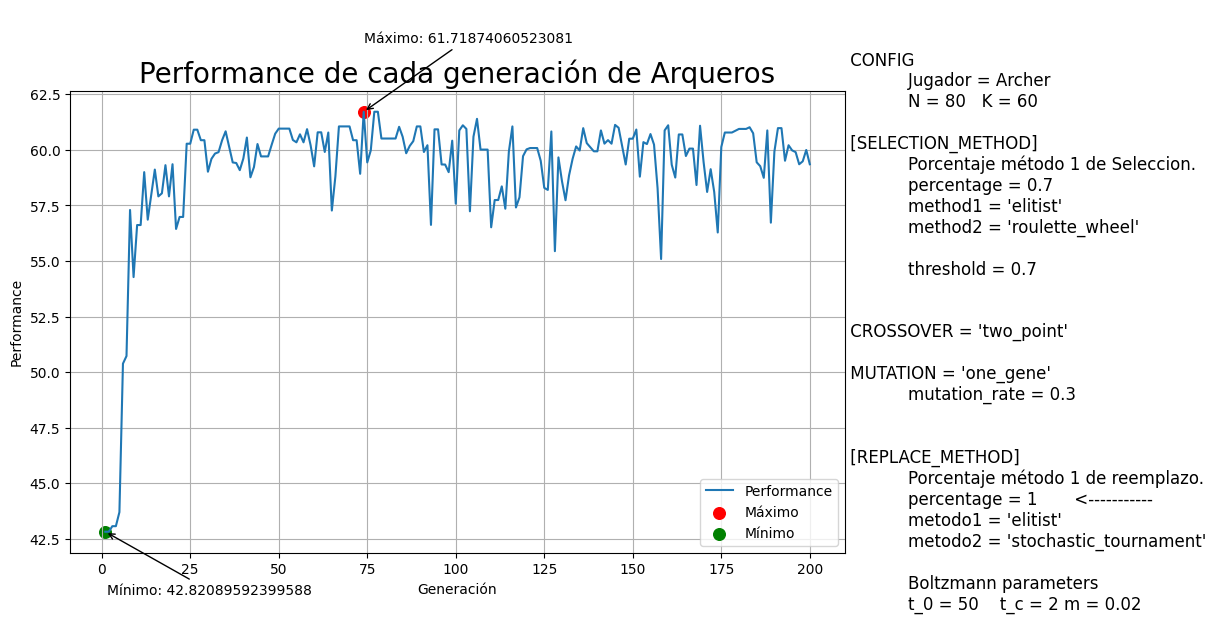

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv('motorAG2r1.csv')           #CAMBIAR AQUI

# Encontrar el valor máximo y mínimo de la columna 'performance'
max_performance = df['performance'].max()
min_performance = df['performance'].min()

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(df['generation'], df['performance'], label='Performance')
plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=70)
plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=70)
plt.xlabel('Generación')
plt.ylabel('Performance')
plt.title('Performance de cada generación de Arqueros', fontsize=20)       #CAMBIAR AQUI
plt.legend()
plt.grid(True)

# Anotar los valores mínimo y máximo
plt.annotate(f'Máximo: {max_performance}', 
             xy=(df['generation'].iloc[df['performance'].idxmax()], max_performance),
             xytext=(0, 50), textcoords='offset points',
             arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.annotate(f'Mínimo: {min_performance}', 
             xy=(df['generation'].iloc[df['performance'].idxmin()], min_performance),
             xytext=(1, -45), textcoords='offset points',
             arrowprops=dict(facecolor='green', arrowstyle='->'))

# Información adicional hacia la derecha de la leyenda del eje x           #CAMBIAR ABAJO
plt.text(1.0, 0.5, """
            \n CONFIG            
            Jugador = Archer
            N = 80   K = 60       
            \n [SELECTION_METHOD]
            Porcentaje método 1 de Seleccion.
            percentage = 0.7
            method1 = 'elitist'
            method2 = 'roulette_wheel'
             
            threshold = 0.7                              
            
            \n CROSSOVER = 'two_point'            
            \n MUTATION = 'one_gene'
            mutation_rate = 0.3

            \n [REPLACE_METHOD] 
            Porcentaje método 1 de reemplazo.
            percentage = 1       <-----------       
            metodo1 = 'elitist'
            metodo2 = 'stochastic_tournament'
            
            Boltzmann parameters
            t_0 = 50    t_c = 2 m = 0.02  
            """,
         horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes , fontsize=12)

# Agregar línea debajo del texto
#plt.axhline(y=0.1, color='gray', linestyle='--')

plt.show()


#### Graph

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def graph(file,title):
    # Cargar los datos desde el archivo CSV
    df = pd.read_csv(file)

    # Encontrar el valor máximo y mínimo de la columna 'performance'
    max_performance = df['performance'].max()
    min_performance = df['performance'].min()

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df['performance'], label='Performance', s=10)
    #plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=7)
    #plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=7)
    plt.xlabel('Individuos')
    plt.ylabel('Performance')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

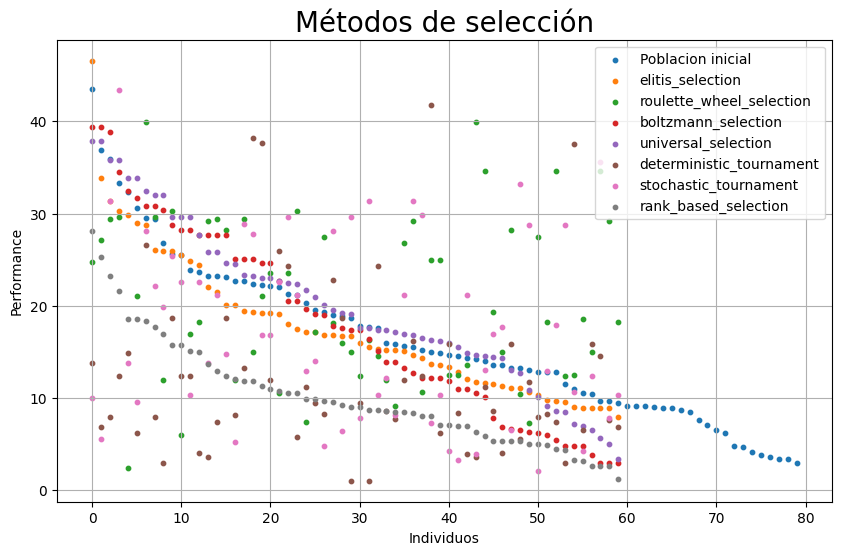

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


# Cargar los datos desde el archivo CSV
df = pd.read_csv('generation0.csv')
df1 = pd.read_csv('elitist_selection.csv')
df2 = pd.read_csv('roulette_wheel_selection.csv')
df3 = pd.read_csv('boltzmann_selection.csv')
df4 = pd.read_csv('universal_selection.csv')
df5 = pd.read_csv('deterministic_tournament.csv')
df6 = pd.read_csv('stochastic_tournament_selection.csv')
df7 = pd.read_csv('rank_based_selection.csv')
# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['performance'], label='Poblacion inicial', s=10)
plt.scatter(df1.index, df1['performance'], label='elitis_selection', s=10)
plt.scatter(df2.index, df2['performance'], label='roulette_wheel_selection', s=10)
plt.scatter(df3.index, df3['performance'], label='boltzmann_selection', s=10)
plt.scatter(df4.index, df4['performance'], label='universal_selection', s=10)
plt.scatter(df5.index, df5['performance'], label='deterministic_tournament', s=10)
plt.scatter(df6.index, df6['performance'], label='stochastic_tournament', s=10)
plt.scatter(df7.index, df7['performance'], label='rank_based_selection', s=10)
plt.xlabel('Individuos')
plt.ylabel('Performance')
plt.title('Métodos de selección', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

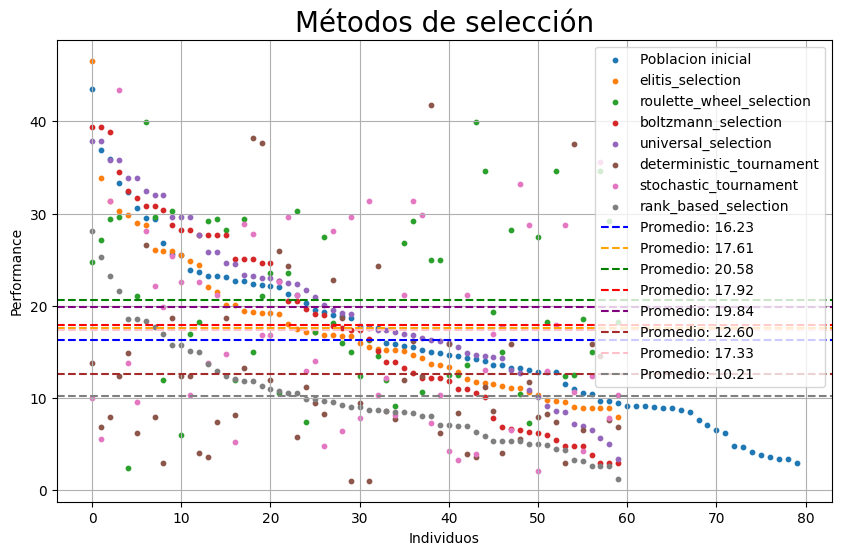

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv('generation0.csv')
df1 = pd.read_csv('elitist_selection.csv')
df2 = pd.read_csv('roulette_wheel_selection.csv')
df3 = pd.read_csv('boltzmann_selection.csv')
df4 = pd.read_csv('universal_selection.csv')
df5 = pd.read_csv('deterministic_tournament.csv')
df6 = pd.read_csv('stochastic_tournament_selection.csv')
df7 = pd.read_csv('rank_based_selection.csv')

# Calcular los promedios de cada conjunto de datos
promedio_df = df['performance'].mean()
promedio_df1 = df1['performance'].mean()
promedio_df2 = df2['performance'].mean()
promedio_df3 = df3['performance'].mean()
promedio_df4 = df4['performance'].mean()
promedio_df5 = df5['performance'].mean()
promedio_df6 = df6['performance'].mean()
promedio_df7 = df7['performance'].mean()

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['performance'], label='Poblacion inicial', s=10)
plt.scatter(df1.index, df1['performance'], label='elitis_selection', s=10)
plt.scatter(df2.index, df2['performance'], label='roulette_wheel_selection', s=10)
plt.scatter(df3.index, df3['performance'], label='boltzmann_selection', s=10)
plt.scatter(df4.index, df4['performance'], label='universal_selection', s=10)
plt.scatter(df5.index, df5['performance'], label='deterministic_tournament', s=10)
plt.scatter(df6.index, df6['performance'], label='stochastic_tournament', s=10)
plt.scatter(df7.index, df7['performance'], label='rank_based_selection', s=10)

# Añadir líneas horizontales para los promedios
plt.axhline(y=promedio_df, color='blue', linestyle='--', label=f'Promedio: {promedio_df:.2f}')
plt.axhline(y=promedio_df1, color='orange', linestyle='--', label=f'Promedio: {promedio_df1:.2f}')
plt.axhline(y=promedio_df2, color='green', linestyle='--', label=f'Promedio: {promedio_df2:.2f}')
plt.axhline(y=promedio_df3, color='red', linestyle='--', label=f'Promedio: {promedio_df3:.2f}')
plt.axhline(y=promedio_df4, color='purple', linestyle='--', label=f'Promedio: {promedio_df4:.2f}')
plt.axhline(y=promedio_df5, color='brown', linestyle='--', label=f'Promedio: {promedio_df5:.2f}')
plt.axhline(y=promedio_df6, color='pink', linestyle='--', label=f'Promedio: {promedio_df6:.2f}')
plt.axhline(y=promedio_df7, color='gray', linestyle='--', label=f'Promedio: {promedio_df7:.2f}')

plt.xlabel('Individuos')
plt.ylabel('Performance')
plt.title('Métodos de selección', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()


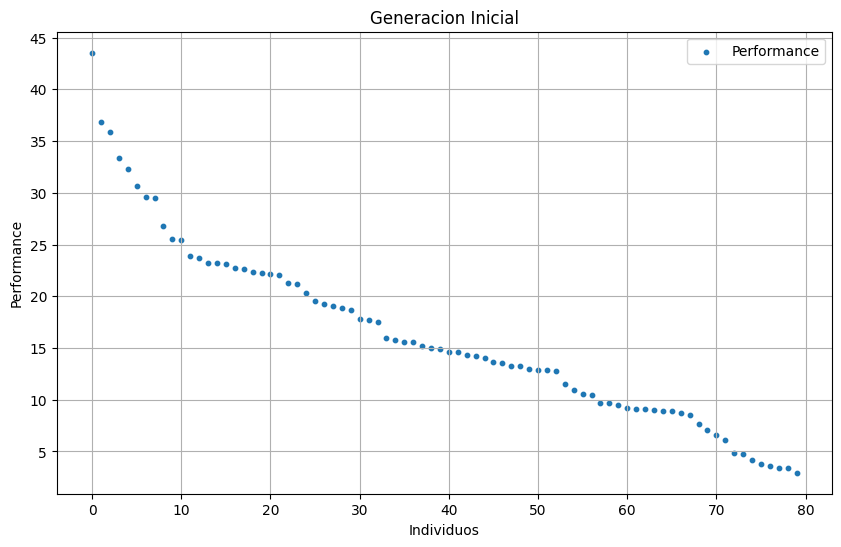

In [92]:
csv = 'generation0.csv'
titulo = 'Generacion Inicial'
graph(csv,titulo)

##### Selections

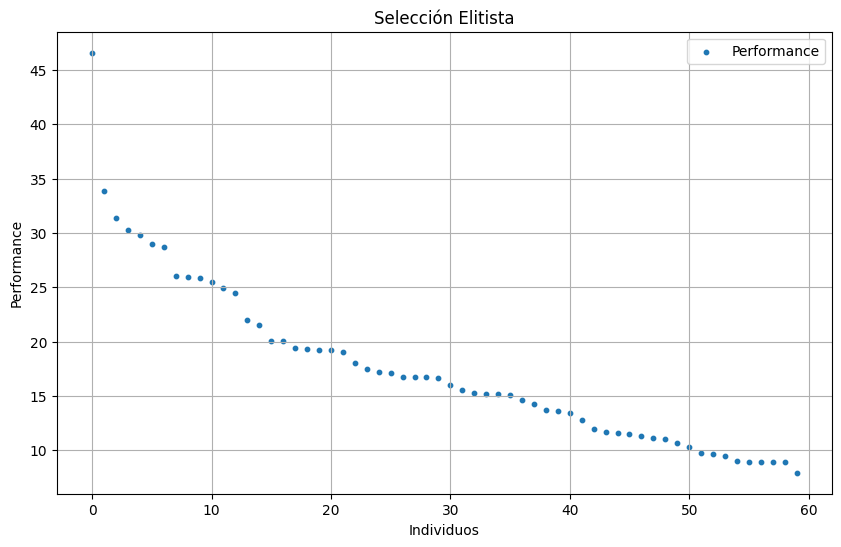

In [33]:
csv = 'elitist_selection.csv'
titulo = 'Selección Elitista'
graph(csv,titulo)

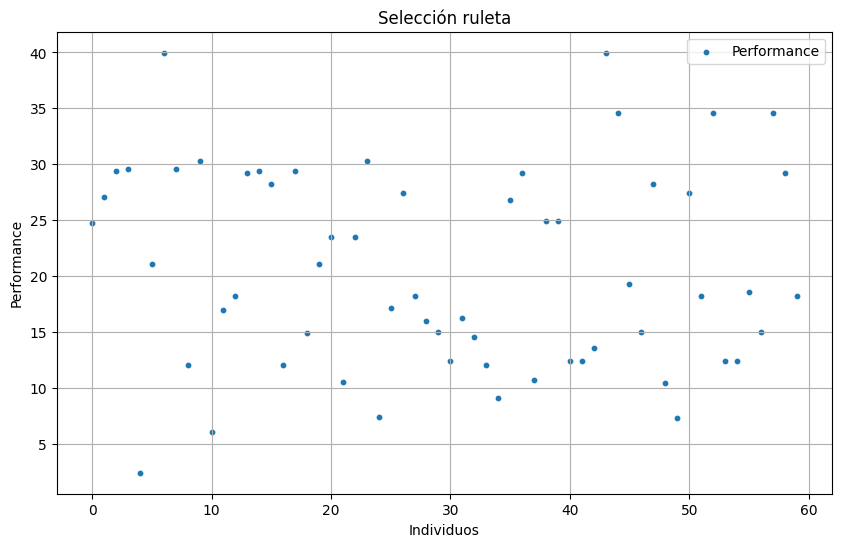

In [34]:
csv = 'roulette_wheel_selection.csv'
titulo = 'Selección ruleta'
graph(csv,titulo)

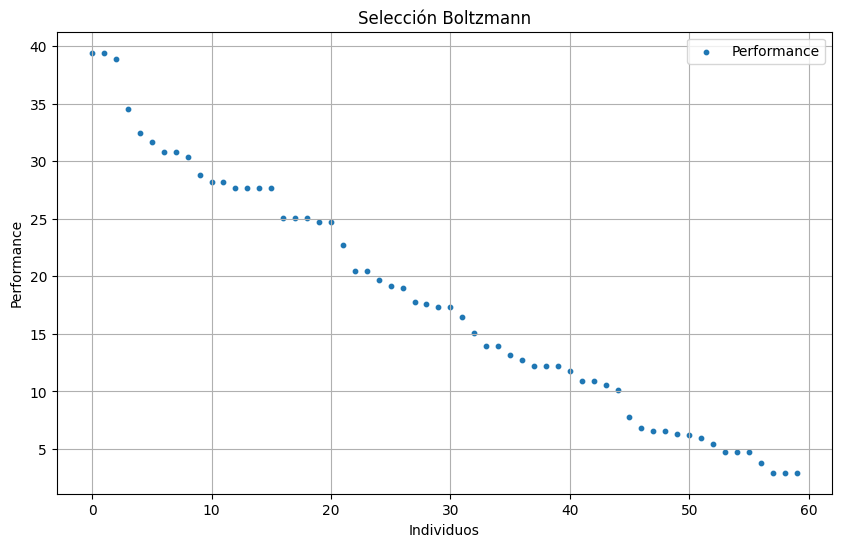

In [35]:
csv = 'boltzmann_selection.csv'
titulo = 'Selección Boltzmann'
graph(csv,titulo)

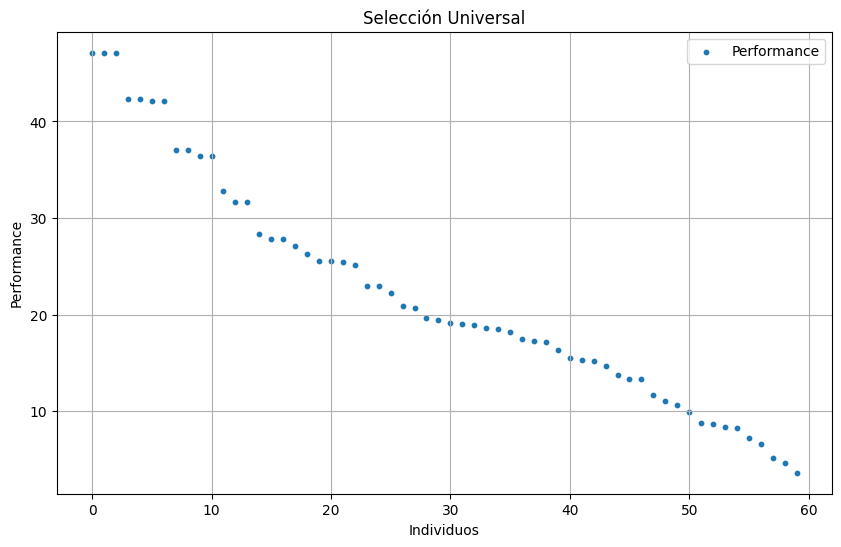

In [36]:
csv = 'universal_selection.csv'
titulo = 'Selección Universal'
graph(csv,titulo)

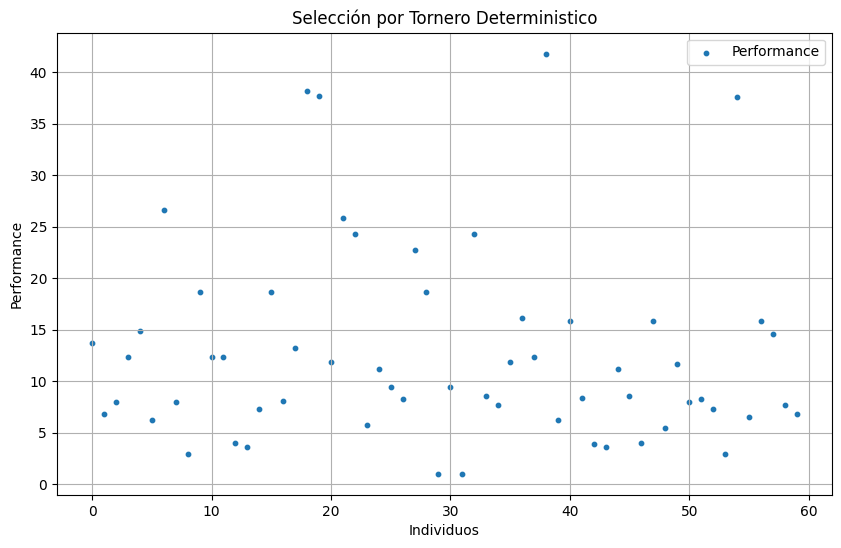

In [37]:
csv = 'deterministic_tournament.csv'
titulo = 'Selección por Tornero Deterministico'
graph(csv,titulo)

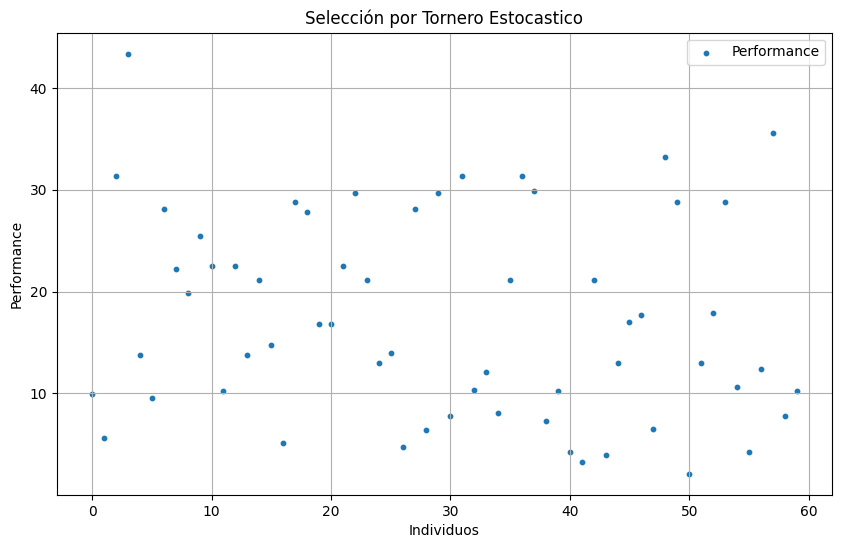

In [38]:
csv = 'stochastic_tournament_selection.csv'
titulo = 'Selección por Tornero Estocastico'
graph(csv,titulo)

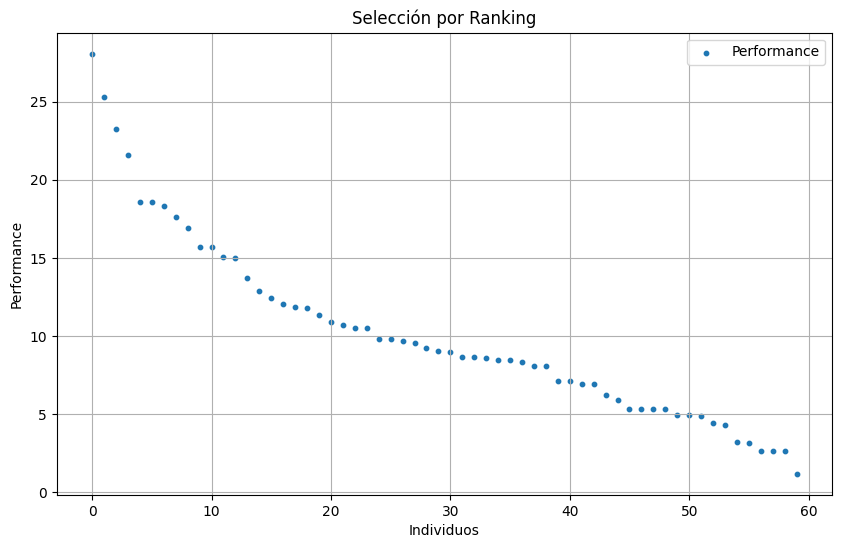

In [11]:
csv = 'rank_based_selection.csv'
titulo = 'Selección por Ranking'
graph(csv,titulo)


##### Crossovers

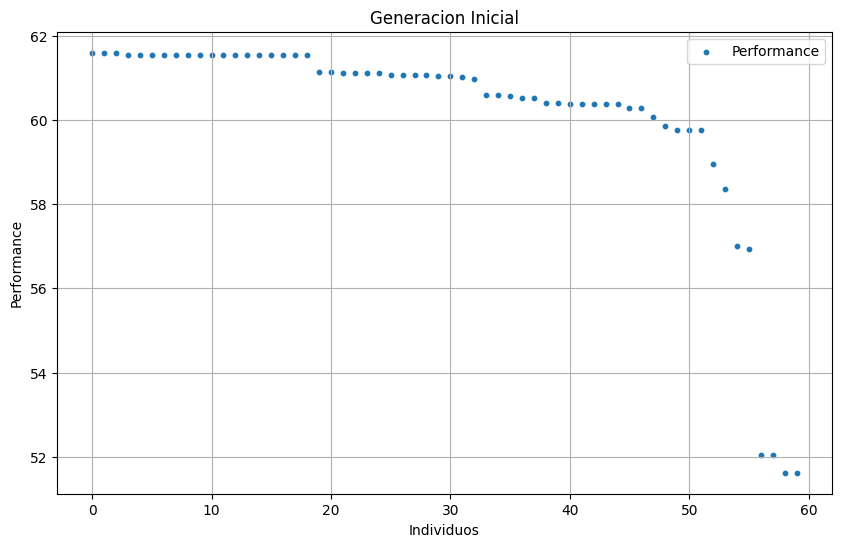

In [7]:
csv = 'selection_total.csv'
titulo = 'Generacion Inicial'
graph(csv,titulo)

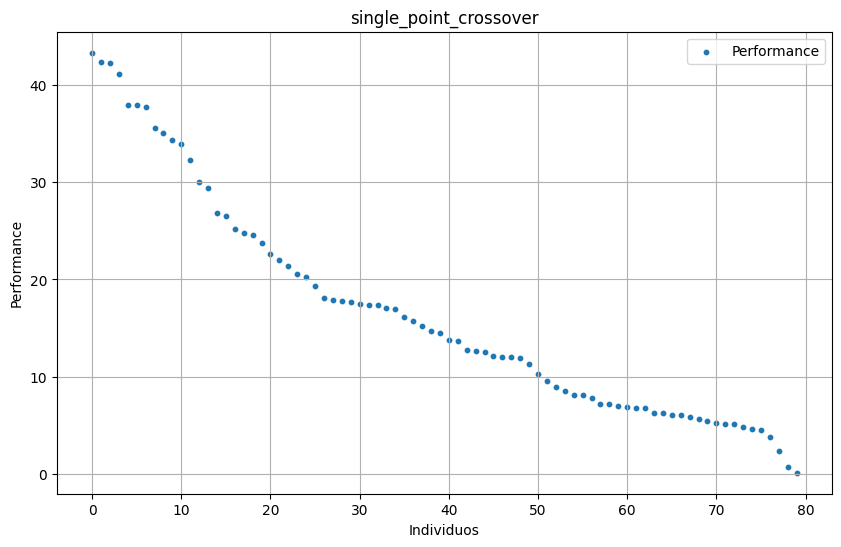

In [40]:
csv = 'single_point_crossover.csv'
titulo = 'single_point_crossover'
graph(csv,titulo)

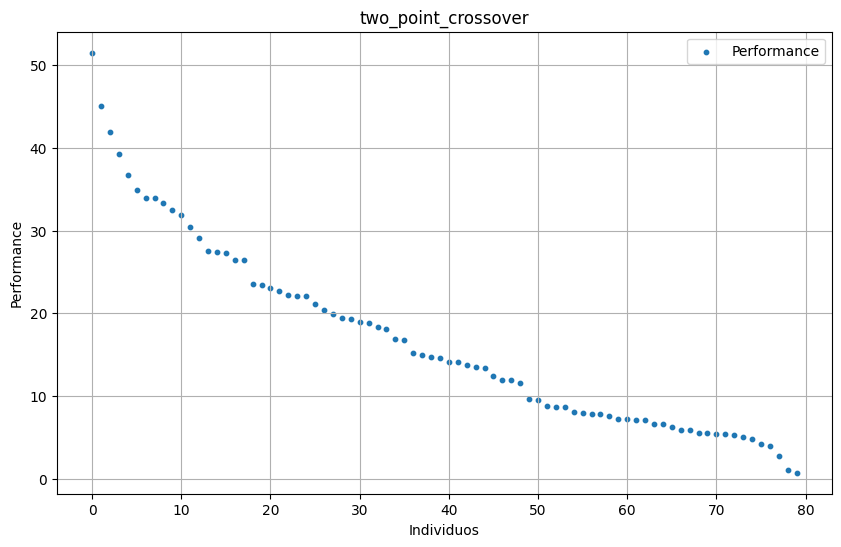

In [41]:
csv = 'two_point_crossover.csv'
titulo = 'two_point_crossover'
graph(csv,titulo)

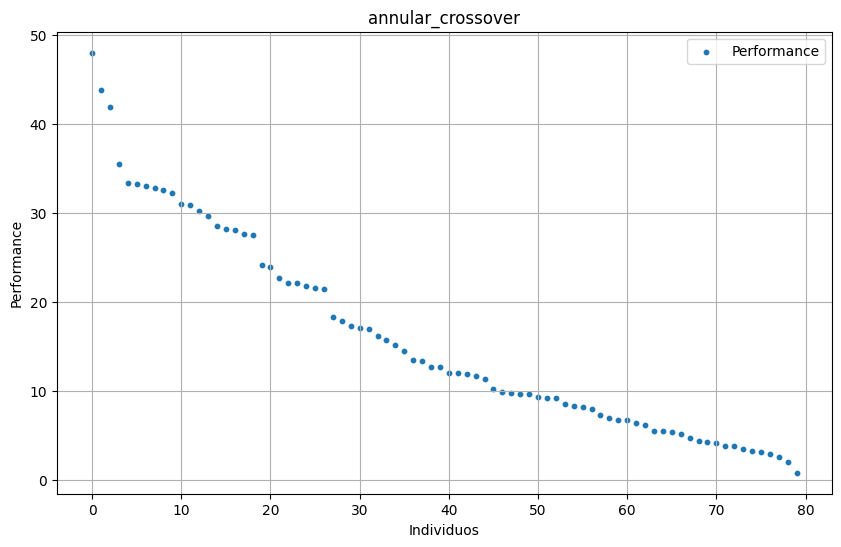

In [42]:
csv = 'annular_crossover.csv'
titulo = 'annular_crossover'
graph(csv,titulo)

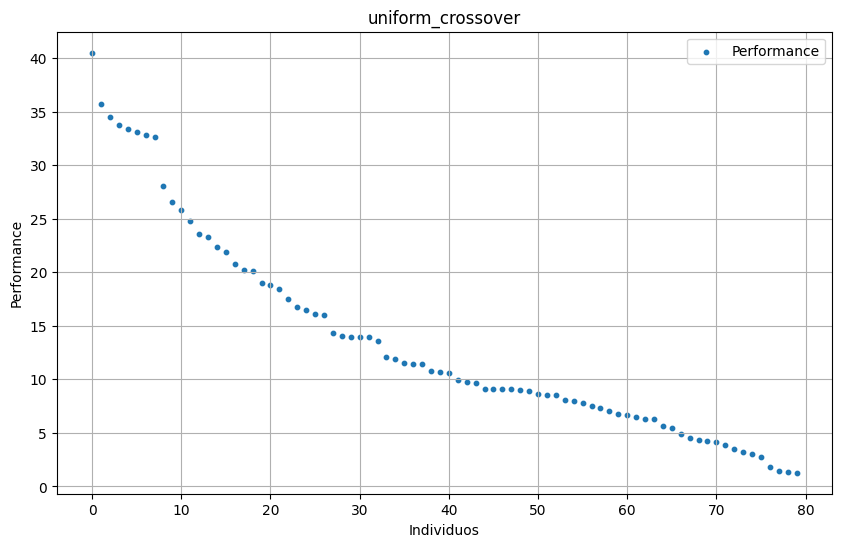

In [86]:
csv = 'uniform_crossover.csv'
titulo = 'uniform_crossover'
graph(csv,titulo)

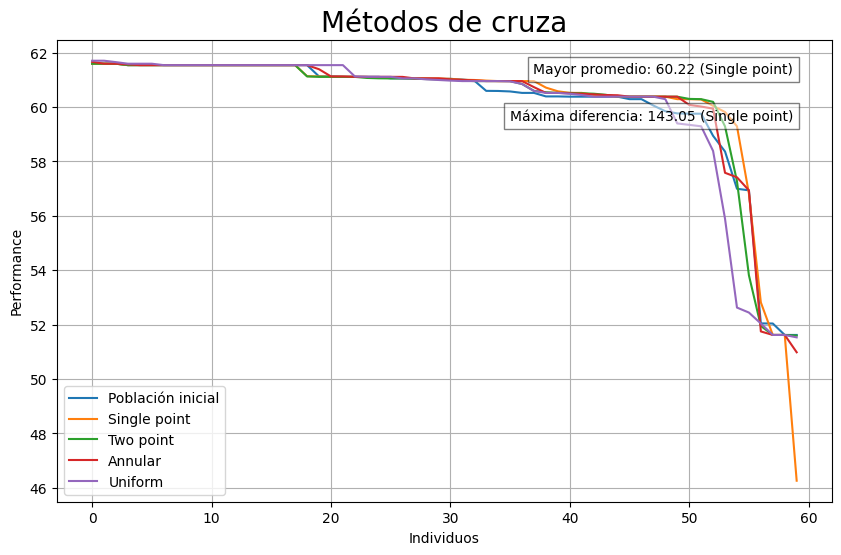

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar los datos desde el archivo CSV
df = pd.read_csv('selection_total.csv')
df1 = pd.read_csv('single_point_crossover.csv')
df2 = pd.read_csv('two_point_crossover.csv')
df3 = pd.read_csv('annular_crossover.csv')
df4 = pd.read_csv('uniform_crossover.csv')

# Calcular la diferencia entre los valores de 'performance' de df y df1
diff_df_df1 = np.linalg.norm(df['performance'].values - df1['performance'].values)

# Calcular la diferencia entre los valores de 'performance' de df y df2
diff_df_df2 = np.linalg.norm(df['performance'].values - df2['performance'].values)

# Calcular la diferencia entre los valores de 'performance' de df y df3
diff_df_df3 = np.linalg.norm(df['performance'].values - df3['performance'].values)

# Calcular la diferencia entre los valores de 'performance' de df y df4
diff_df_df4 = np.linalg.norm(df['performance'].values - df4['performance'].values)

# Calcular el promedio de cada conjunto de datos
promedio_df1 = df1['performance'].mean()
promedio_df2 = df2['performance'].mean()
promedio_df3 = df3['performance'].mean()
promedio_df4 = df4['performance'].mean()

# Encontrar el máximo promedio
max_promedio = max(promedio_df1, promedio_df2, promedio_df3)
if max_promedio == promedio_df1:
    max_label = 'Single point'
    #max_diff = diff_df_df1
elif max_promedio == promedio_df2:
    max_label = 'Two point'
    #max_diff = diff_df_df2
elif max_promedio == promedio_df3:
    max_label = 'Annular'
    #max_diff = diff_df_df2
else:
    max_label = 'Uniform'
    #max_diff = diff_df_df3

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['performance'], label='Población inicial')
plt.plot(df1.index, df1['performance'], label='Single point')
plt.plot(df2.index, df2['performance'], label='Two point')
plt.plot(df3.index, df3['performance'], label='Annular')
plt.plot(df4.index, df4['performance'], label='Uniform')

# Añadir texto para indicar el promedio más alto
plt.text(0.95, 0.95, f'Mayor promedio: {max_promedio:.2f} ({max_label})',
         transform=plt.gca().transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# Añadir texto para indicar la máxima diferencia y a quién corresponde
plt.text(0.95, 0.85, f'Máxima diferencia: {max_diff:.2f} ({max_label})',
         transform=plt.gca().transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel('Individuos')
plt.ylabel('Performance')
plt.title('Métodos de cruza', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

##### Mutations

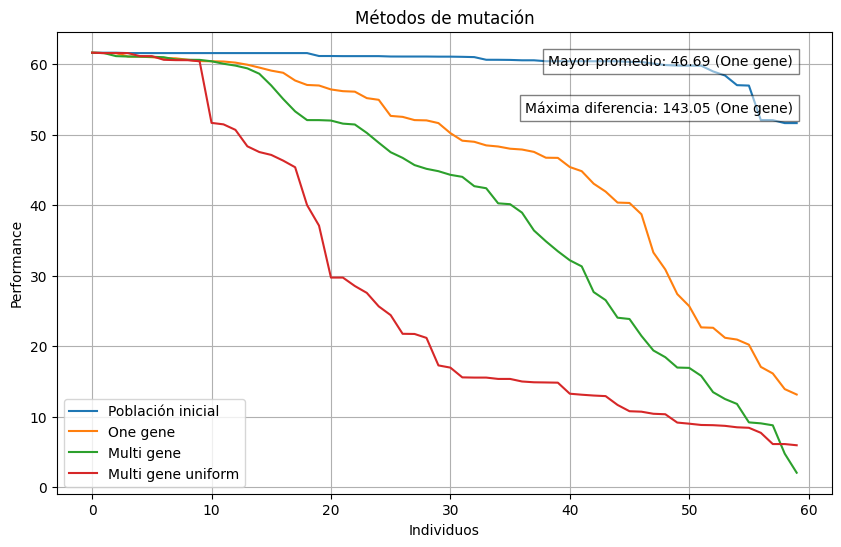

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar los datos desde el archivo CSV
df = pd.read_csv('selection_total.csv')
df1 = pd.read_csv('one_gene_mutation.csv')
df2 = pd.read_csv('multi_gene_mutation.csv')
df3 = pd.read_csv('multi_gene_mutation_uniform.csv')

# Calcular la diferencia entre los valores de 'performance' de df y df1
diff_df_df1 = np.linalg.norm(df['performance'].values - df1['performance'].values)

# Calcular la diferencia entre los valores de 'performance' de df y df2
diff_df_df2 = np.linalg.norm(df['performance'].values - df2['performance'].values)

# Calcular la diferencia entre los valores de 'performance' de df y df3
diff_df_df3 = np.linalg.norm(df['performance'].values - df3['performance'].values)

# Calcular el promedio de cada conjunto de datos
promedio_df1 = df1['performance'].mean()
promedio_df2 = df2['performance'].mean()
promedio_df3 = df3['performance'].mean()

# Encontrar el máximo promedio
max_promedio = max(promedio_df1, promedio_df2, promedio_df3)
if max_promedio == promedio_df1:
    max_label = 'One gene'
    #max_diff = diff_df_df1
elif max_promedio == promedio_df2:
    max_label = 'Multi gene'
    #max_diff = diff_df_df2
else:
    max_label = 'Multi gene uniform'
    #max_diff = diff_df_df3

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['performance'], label='Población inicial')
plt.plot(df1.index, df1['performance'], label='One gene')
plt.plot(df2.index, df2['performance'], label='Multi gene')
plt.plot(df3.index, df3['performance'], label='Multi gene uniform')

# Añadir texto para indicar el promedio más alto
plt.text(0.95, 0.95, f'Mayor promedio: {max_promedio:.2f} ({max_label})',
         transform=plt.gca().transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# Añadir texto para indicar la máxima diferencia y a quién corresponde
plt.text(0.95, 0.85, f'Máxima diferencia: {max_diff:.2f} ({max_label})',
         transform=plt.gca().transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel('Individuos')
plt.ylabel('Performance')
plt.title('Métodos de mutación')
plt.legend()
plt.grid(True)
plt.show()


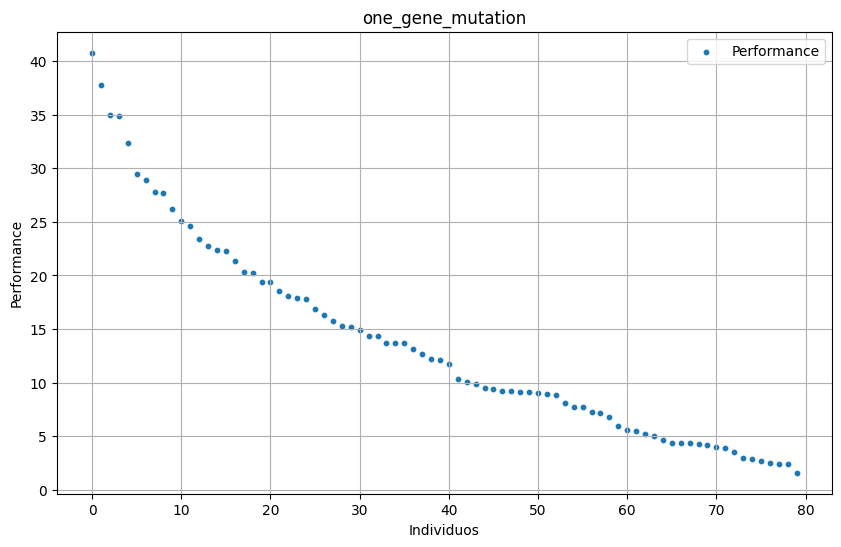

In [44]:
csv = 'one_gene_mutation.csv'
titulo = 'one_gene_mutation'
graph(csv,titulo)

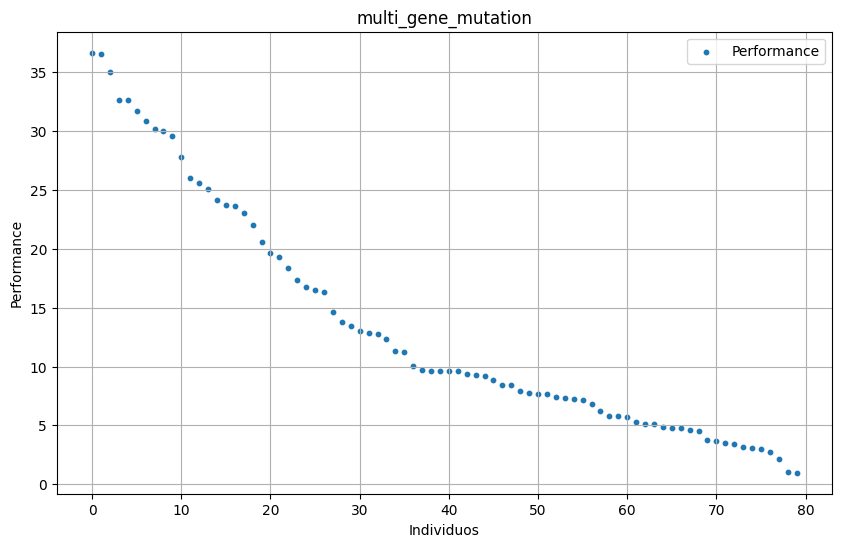

In [45]:
csv = 'multi_gene_mutation.csv'
titulo = 'multi_gene_mutation'
graph(csv,titulo)

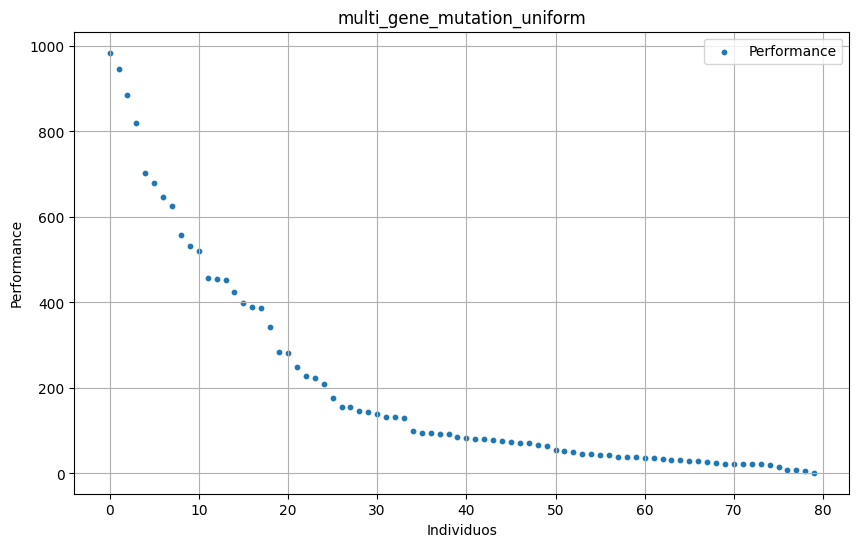

In [46]:
csv = 'multi_gene_mutation_uniform.csv'
titulo = 'multi_gene_mutation_uniform'
graph(csv,titulo)

##### Grafica del Motor AG

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv("datos-Prueba1.csv")

# Encontrar el valor máximo y mínimo de la columna 'performance'
max_performance = df['performance'].max()
min_performance = df['performance'].min()

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df['generation'], df['performance'], label='Performance', s=3)
plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=7)
plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=7)
plt.xlabel('Generación')
plt.ylabel('Performance')
plt.title('Performance por generaciones')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
Desempeño(Fuerzai,Agilidadi,Periciai,Resistenciai,Vidai,h) =
	0.6 * (((tanh(0.01 ∗ Agilidadi)) +  (0.6 ∗ tanh(0.01 ∗ Periciai))) ∗ (100 ∗ tanh(0.01 ∗ Fuerzai)) ∗ (0,5 − (3h − 5)^4 + (3h − 5)^2 + h/2)) + 
	0.4 * (((tanh(0.01 ∗ Resistenciai)) + (0.6 ∗ tanh(0.01 ∗ Periciai))) ∗ (100 ∗ tanh(0.01 ∗ Vidai)) ∗ (2 + (3h − 5)^4 − (3h − 5)^2 − h/2))
"""

### Comparativa con SCIPY.Optimize

In [66]:
from scipy.optimize import minimize
import numpy as np

def desempeno(vars):
    Fuerzai, Agilidadi, Periciai, Resistenciai, Vidai, h = vars
    
    term1 = 0.6 * (((np.tanh(0.01 * Agilidadi)) +  (0.6 * np.tanh(0.01 * Periciai))) * (100 * np.tanh(0.01 * Fuerzai)) * (0.5 - (3*h - 5)**4 + (3*h - 5)**2 + h/2))
    term2 = 0.4 * (((np.tanh(0.01 * Resistenciai)) + (0.6 * np.tanh(0.01 * Periciai))) * (100 * np.tanh(0.01 * Vidai)) * (2 + (3*h - 5)**4 - (3*h - 5)**2 - h/2))
    
    return -(term1 + term2)  # Maximizamos negando la función de desempeño para convertirla en un problema de minimización

# Restricción de suma de variables
def suma_variables(vars):
    Fuerzai, Agilidadi, Periciai, Resistenciai, Vidai, h = vars
    return 150 - (Fuerzai + Agilidadi + Periciai + Resistenciai + Vidai)

# Restricciones para h
restricciones = [{'type': 'eq', 'fun': suma_variables},
                 {'type': 'ineq', 'fun': lambda x: x[5] - 1.3},  # h >= 1.3
                 {'type': 'ineq', 'fun': lambda x: 2.0 - x[5]}]  # h <= 2.0

# Valores iniciales para las variables independientes
x0 = [1, 1, 1, 1, 1, 1]

# Llamada al optimizador
resultado = minimize(desempeno, x0, bounds=((0, None), (0, None), (0, None), (0, None), (0, None), (1.3, 2.0)),
                     constraints=restricciones)

# Imprimir resultados
print("Para GUERERO")
print("Valores óptimos de las variables independientes:", resultado.x)
print("Valor máximo de la función de desempeño:", -resultado.fun)  # Nota: revertimos el signo para obtener el máximo


Para GUERERO
Valores óptimos de las variables independientes: [7.48212326e+01 7.45514268e+01 6.27340660e-01 7.97819883e-12
 1.59506722e-11 1.44632161e+00]
Valor máximo de la función de desempeño: 35.56207017071792


In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv('motorAGWarrior.csv')           #CAMBIAR AQUI

df.iloc[df['performance'].idxmax()]

strength                7.50000000e+01
agility                 7.50000000e+01
expertise               0.00000000e+00
resistance              0.00000000e+00
life                    0.00000000e+00
height                  1.90000000e+00
characterType    CharacterType.WARRIOR
performance             4.11458271e+01
generation                          18
Name: 17, dtype: object

In [67]:
from scipy.optimize import minimize
import numpy as np

def desempeno(vars):
    Fuerzai, Agilidadi, Periciai, Resistenciai, Vidai, h = vars
    
    term1 = 0.9 * (((np.tanh(0.01 * Agilidadi)) +  (0.6 * np.tanh(0.01 * Periciai))) * (100 * np.tanh(0.01 * Fuerzai)) * (0.5 - (3*h - 5)**4 + (3*h - 5)**2 + h/2))
    term2 = 0.1 * (((np.tanh(0.01 * Resistenciai)) + (0.6 * np.tanh(0.01 * Periciai))) * (100 * np.tanh(0.01 * Vidai)) * (2 + (3*h - 5)**4 - (3*h - 5)**2 - h/2))
    
    return -(term1 + term2)  # Maximizamos negando la función de desempeño para convertirla en un problema de minimización

# Restricción de suma de variables
def suma_variables(vars):
    Fuerzai, Agilidadi, Periciai, Resistenciai, Vidai, h = vars
    return 150 - (Fuerzai + Agilidadi + Periciai + Resistenciai + Vidai)

# Restricciones para h
restricciones = [{'type': 'eq', 'fun': suma_variables},
                 {'type': 'ineq', 'fun': lambda x: x[5] - 1.3},  # h >= 1.3
                 {'type': 'ineq', 'fun': lambda x: 2.0 - x[5]}]  # h <= 2.0

# Valores iniciales para las variables independientes
x0 = [1, 1, 1, 1, 1, 1]

# Llamada al optimizador
resultado = minimize(desempeno, x0, bounds=((0, None), (0, None), (0, None), (0, None), (0, None), (1.3, 2.0)),
                     constraints=restricciones)

# Imprimir resultados
print("Para ARQUERO")
print("Valores óptimos de las variables independientes:", resultado.x)
print("Valor máximo de la función de desempeño:", -resultado.fun)  # Nota: revertimos el signo para obtener el máximo


Para ARQUERO
Valores óptimos de las variables independientes: [74.82033679 74.5557468   0.62391642  0.          0.          1.915198  ]
Valor máximo de la función de desempeño: 61.88581858271828


In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv('datos-Prueba1.csv')           #CAMBIAR AQUI

df.iloc[df['performance'].idxmax()]

strength                           64
agility                            32
expertise                          40
resistance                          4
life                               10
height                 1.80000000e+00
characterType    CharacterType.ARCHER
performance            4.21865958e+01
generation                          1
Name: 0, dtype: object

In [68]:
from scipy.optimize import minimize
import numpy as np

def desempeno(vars):
    Fuerzai, Agilidadi, Periciai, Resistenciai, Vidai, h = vars
    
    term1 = 0.1 * (((np.tanh(0.01 * Agilidadi)) +  (0.6 * np.tanh(0.01 * Periciai))) * (100 * np.tanh(0.01 * Fuerzai)) * (0.5 - (3*h - 5)**4 + (3*h - 5)**2 + h/2))
    term2 = 0.9 * (((np.tanh(0.01 * Resistenciai)) + (0.6 * np.tanh(0.01 * Periciai))) * (100 * np.tanh(0.01 * Vidai)) * (2 + (3*h - 5)**4 - (3*h - 5)**2 - h/2))
    
    return -(term1 + term2)  # Maximizamos negando la función de desempeño para convertirla en un problema de minimización

# Restricción de suma de variables
def suma_variables(vars):
    Fuerzai, Agilidadi, Periciai, Resistenciai, Vidai, h = vars
    return 150 - (Fuerzai + Agilidadi + Periciai + Resistenciai + Vidai)

# Restricciones para h
restricciones = [{'type': 'eq', 'fun': suma_variables},
                 {'type': 'ineq', 'fun': lambda x: x[5] - 1.3},  # h >= 1.3
                 {'type': 'ineq', 'fun': lambda x: 2.0 - x[5]}]  # h <= 2.0

# Valores iniciales para las variables independientes
x0 = [1, 1, 1, 1, 1, 1]

# Llamada al optimizador
resultado = minimize(desempeno, x0, bounds=((0, None), (0, None), (0, None), (0, None), (0, None), (1.3, 2.0)),
                     constraints=restricciones)

# Imprimir resultados
print("Para DEFENSOR")
print("Valores óptimos de las variables independientes:", resultado.x)
print("Valor máximo de la función de desempeño:", -resultado.fun)  # Nota: revertimos el signo para obtener el máximo


Para DEFENSOR
Valores óptimos de las variables independientes: [1.24319009e-06 1.20110827e-06 6.08635124e-01 7.45583851e+01
 7.48329774e+01 1.30000000e+00]
Valor máximo de la función de desempeño: 58.24148270721618


In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv('motorAGDefender.csv')           #CAMBIAR AQUI

df.iloc[df['performance'].idxmax()]

strength                 0.00000000e+00
agility                  0.00000000e+00
expertise                0.00000000e+00
resistance               7.50000000e+01
life                     7.50000000e+01
height                   1.30000000e+00
characterType    CharacterType.DEFENDER
performance              5.82405034e+01
generation                           78
Name: 77, dtype: object

In [69]:
from scipy.optimize import minimize
import numpy as np

def desempeno(vars):
    Fuerzai, Agilidadi, Periciai, Resistenciai, Vidai, h = vars
    
    term1 = 0.8 * (((np.tanh(0.01 * Agilidadi)) +  (0.6 * np.tanh(0.01 * Periciai))) * (100 * np.tanh(0.01 * Fuerzai)) * (0.5 - (3*h - 5)**4 + (3*h - 5)**2 + h/2))
    term2 = 0.3 * (((np.tanh(0.01 * Resistenciai)) + (0.6 * np.tanh(0.01 * Periciai))) * (100 * np.tanh(0.01 * Vidai)) * (2 + (3*h - 5)**4 - (3*h - 5)**2 - h/2))
    
    return -(term1 + term2)  # Maximizamos negando la función de desempeño para convertirla en un problema de minimización

# Restricción de suma de variables
def suma_variables(vars):
    Fuerzai, Agilidadi, Periciai, Resistenciai, Vidai, h = vars
    return 150 - (Fuerzai + Agilidadi + Periciai + Resistenciai + Vidai)

# Restricciones para h
restricciones = [{'type': 'eq', 'fun': suma_variables},
                 {'type': 'ineq', 'fun': lambda x: x[5] - 1.3},  # h >= 1.3
                 {'type': 'ineq', 'fun': lambda x: 2.0 - x[5]}]  # h <= 2.0

# Valores iniciales para las variables independientes
x0 = [1, 1, 1, 1, 1, 1]

# Llamada al optimizador
resultado = minimize(desempeno, x0, bounds=((0, None), (0, None), (0, None), (0, None), (0, None), (1.3, 2.0)),
                     constraints=restricciones)

# Imprimir resultados
print("Para INFILTRADO")
print("Valores óptimos de las variables independientes:", resultado.x)
print("Valor máximo de la función de desempeño:", -resultado.fun)  # Nota: revertimos el signo para obtener el máximo


Para INFILTRADO
Valores óptimos de las variables independientes: [74.82120094 74.55193608  0.62686298  0.          0.          1.44632208]
Valor máximo de la función de desempeño: 47.41609356469513


In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv('motorAGInfiltrator.csv')           #CAMBIAR AQUI

df.iloc[df['performance'].idxmax()]

strength                    7.50000000e+01
agility                     7.50000000e+01
expertise                   0.00000000e+00
resistance                  0.00000000e+00
life                        0.00000000e+00
height                      1.90000000e+00
characterType    CharacterType.INFILTRATOR
performance                 5.48611028e+01
generation                              49
Name: 48, dtype: object